Intro to Scalable Computing with Dask in Python

https://www.youtube.com/watch?v=FwhtHOKU8Jk

Parrallelize code with dask.delayed

In [1]:
import time

def inc(x):
    time.sleep(1)
    return x+1

def add(x,y):
    time.sleep(1)
    return x+y

In [2]:
a = 1
b = 2
c = 3

In [3]:
%%time
ai = inc(a)
bi = inc(b)
ci = inc(c)

ab = add(ai,bi)

abc = add(ab,ci)
abc

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 s


9

In [4]:
from dask import delayed
inc_delayed = delayed(inc)

inc_delayed

Delayed('inc-7d893e6c-01bf-4f3d-9041-3206299c1199')

In [5]:
ai = delayed(inc)(a)
ai

Delayed('inc-d3ec4041-fe21-4e1e-b847-50c0444cab2a')

In [7]:
ai = inc_delayed(a)

In [6]:
# to get thea result call compute()
ai.compute()

2

In [8]:
# rewrite with dask.delayed:
ai = delayed(inc)(a)
bi = delayed(inc)(b)
ci = delayed(inc)(c)

ab = delayed(add)(ai,bi)

abc = delayed(add)(ab,ci)
abc

Delayed('add-2323f542-85cd-4881-9d08-3b9e78dff479')

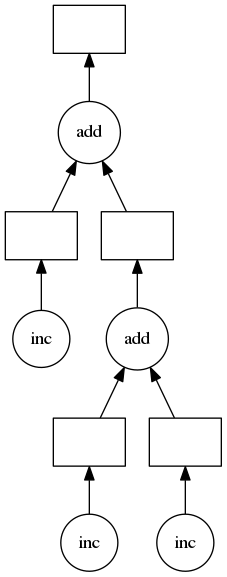

In [9]:
# visualize the delayed object abc (install graphviz)
abc.visualize()

In [10]:
%time abc.compute() # 3 s instead of 5 s

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 3.01 s


9

In [11]:
# for loop example
import numpy as np

for i in range(10):
    x= np.random.randn(10000, 10000) # about 800MB for 100M 64bit-float numbers
    np.save("randarray_{}.npy".format(i),x)

In [13]:
%ls -l rand*.npy

-rw-rw-r-- 1 eolson eolson 800000128 Mar 11 13:45 randarray_0.npy
-rw-rw-r-- 1 eolson eolson 800000128 Mar 11 13:45 randarray_1.npy
-rw-rw-r-- 1 eolson eolson 800000128 Mar 11 13:46 randarray_2.npy
-rw-rw-r-- 1 eolson eolson 800000128 Mar 11 13:46 randarray_3.npy
-rw-rw-r-- 1 eolson eolson 800000128 Mar 11 13:46 randarray_4.npy
-rw-rw-r-- 1 eolson eolson 800000128 Mar 11 13:46 randarray_5.npy
-rw-rw-r-- 1 eolson eolson 800000128 Mar 11 13:46 randarray_6.npy
-rw-rw-r-- 1 eolson eolson 800000128 Mar 11 13:46 randarray_7.npy
-rw-rw-r-- 1 eolson eolson 800000128 Mar 11 13:47 randarray_8.npy
-rw-rw-r-- 1 eolson eolson 800000128 Mar 11 13:47 randarray_9.npy


In [14]:
%%time
from glob import glob

sums = []
for file in glob('rand*.npy'):
    x=np.load(file)
    sums.append(x.sum())
    
result = sum(sums)
result

CPU times: user 480 ms, sys: 2.36 s, total: 2.84 s
Wall time: 9.42 s


-856.6246106500062

In [15]:
%%time
from glob import glob

sums = []
for file in glob('rand*.npy'):
    x=delayed(np.load)(file)
    sums.append(x.sum())
    
result = delayed(sum)(sums)
result

CPU times: user 4 ms, sys: 32 ms, total: 36 ms
Wall time: 36.7 ms


Delayed('sum-c5b061fa-1db3-48c2-92bc-ac5ba89a8ec1')

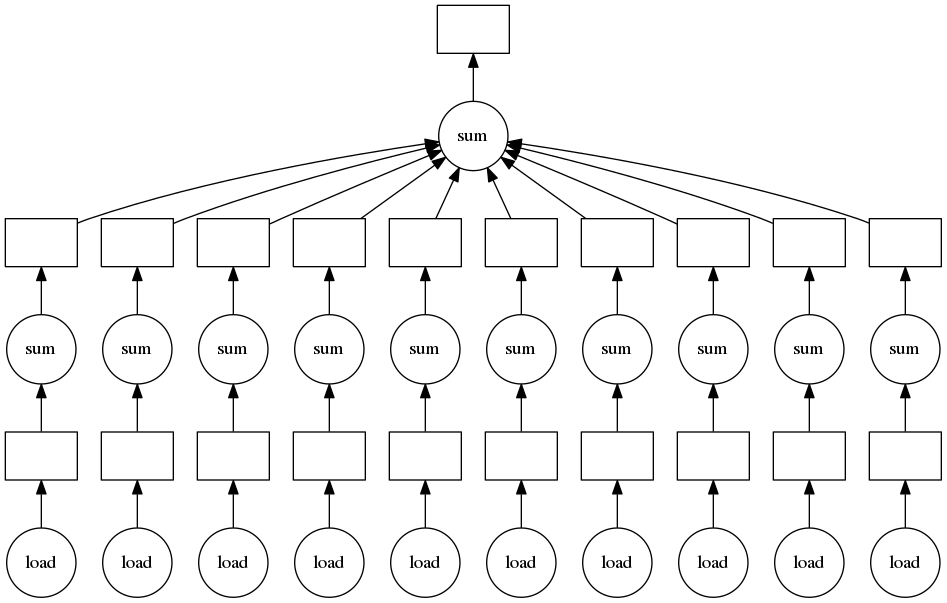

In [16]:
result.visualize()

In [17]:
%time result.compute()

CPU times: user 2.1 s, sys: 6.83 s, total: 8.93 s
Wall time: 2.67 s


-856.6246106500062

In [18]:
import netCDF4 as nc
f=nc.Dataset('/results/SalishSea/nowcast-green.201812/01jan15/SalishSea_1h_20150101_20150101_ptrc_T.nc')
dset=f['nitrate']

In [19]:
%%time
sums = []

for i in range(0, 24,2):
    chunk=dset[i:i+2,:,:,:]
    sums.append(chunk.sum())
    
total = sum(sums)

print(total)

<timed exec>:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


1150428888.0
CPU times: user 4.6 s, sys: 1.4 s, total: 6 s
Wall time: 6.13 s


In [20]:
import dask.array as da

x=da.from_array(dset, chunks=(2,40,898,398))
x

dask.array<array, shape=(24, 40, 898, 398), dtype=float32, chunksize=(2, 40, 898, 398), chunktype=numpy.MaskedArray>

In [21]:
x.sum()

dask.array<sum-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

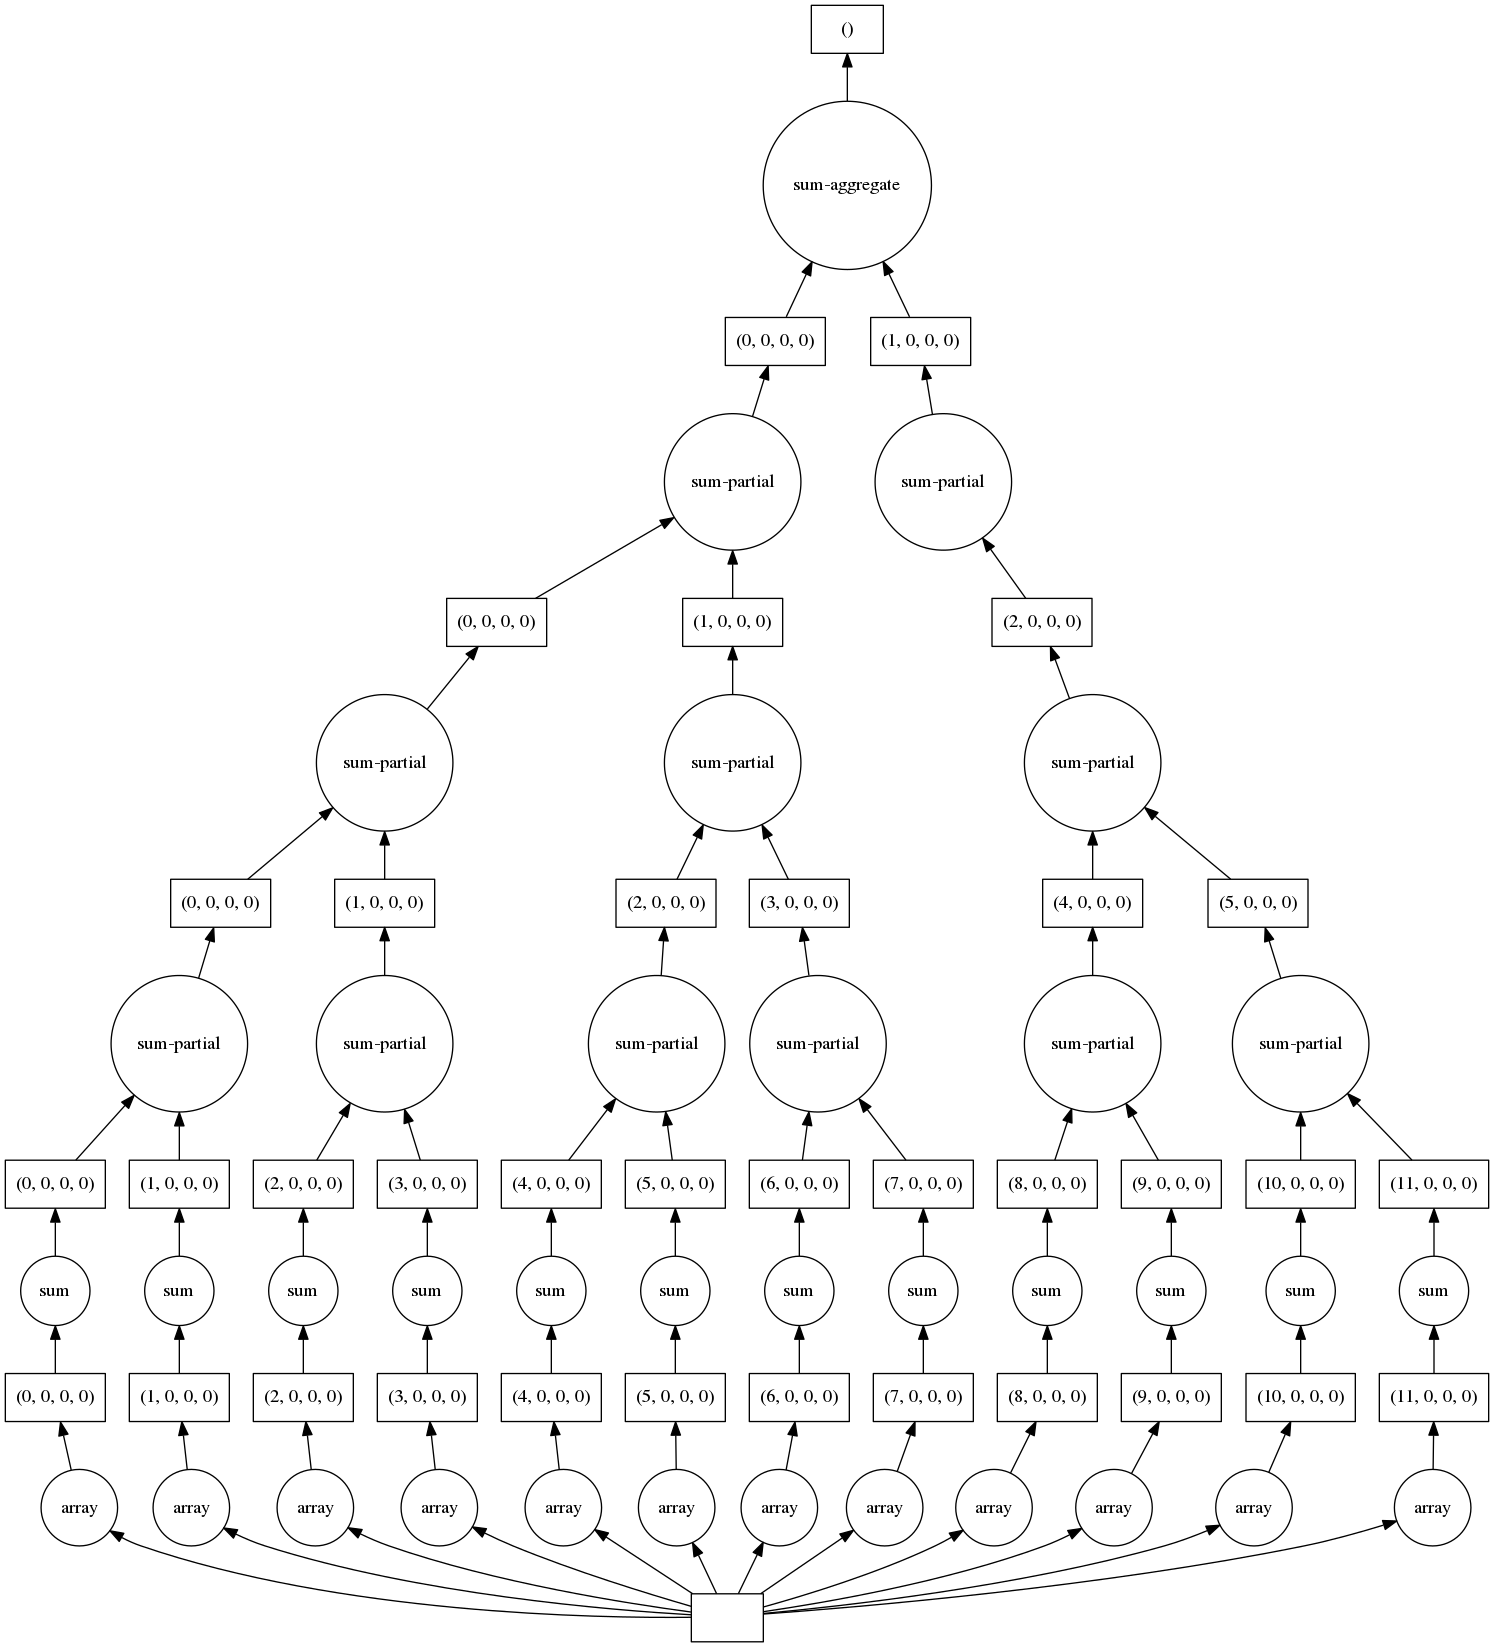

In [22]:
x.sum().visualize()

In [23]:
x.sum().compute()

1.7167788e+28

In [24]:
%time x.sum().compute()

CPU times: user 4.5 s, sys: 1.11 s, total: 5.61 s
Wall time: 4.53 s


1.7167788e+28

In [25]:
# numpy array

In [26]:
%%time
x = np.random.normal(10,0.1,size=(20000,20000)) # 400 million numbers total size about 3.2 gb
y=x.mean(axis=0)[::100]
y

CPU times: user 11.6 s, sys: 500 ms, total: 12.1 s
Wall time: 12.1 s


array([10.00105557, 10.00027755, 10.0000946 , 10.00080965,  9.99945158,
       10.0003414 , 10.00034366,  9.99977327, 10.00002802, 10.00101941,
       10.00042925, 10.00062582, 10.0000207 ,  9.99925918, 10.00014067,
        9.99935874, 10.00035567,  9.99954848,  9.99893803,  9.99989875,
       10.00064967, 10.00031869, 10.00079229, 10.00080091, 10.00038395,
       10.00058608,  9.99947565, 10.00030847, 10.00010256,  9.99956673,
        9.99930605, 10.00036533,  9.99920981,  9.99982416, 10.00022762,
        9.99954354, 10.00093016, 10.00045394,  9.99901991,  9.99934025,
        9.99976787,  9.99999133, 10.00011824, 10.00012267, 10.00120595,
        9.99958385,  9.99887762, 10.00028914,  9.99698833,  9.99954552,
        9.99975111,  9.99877671,  9.99860404, 10.00027856, 10.00007309,
        9.99881318,  9.9988371 , 10.00031981, 10.00043461,  9.99912351,
        9.99957134,  9.99952474, 10.00202085,  9.99969167,  9.99894015,
       10.00026053,  9.9998466 ,  9.99918977, 10.00054605,  9.99

In [27]:
## dask
x = da.random.normal(10,.1,size=(20000,20000),chunks=(1000,1000))
y=x.mean(axis=0)[::100]

In [ ]:
x.

In [28]:
%time y.compute()

CPU times: user 16.9 s, sys: 0 ns, total: 16.9 s
Wall time: 2.23 s


array([10.00013009,  9.99923094,  9.99876587, 10.00007347, 10.0004867 ,
        9.99909369, 10.00053792,  9.99968722,  9.99989641, 10.00010043,
       10.00006592, 10.00083825, 10.00016694,  9.99899799, 10.00055201,
       10.00024364, 10.00037939,  9.99914961,  9.99990806, 10.00159043,
        9.99981461, 10.00084373,  9.99922173,  9.99929332, 10.00028147,
       10.00053363,  9.99956353, 10.00027231, 10.00084656, 10.00039469,
        9.99986796,  9.99851751, 10.00080217,  9.99999756, 10.00094955,
        9.99996576, 10.00005437, 10.00050925,  9.99894682, 10.00009948,
       10.00003288, 10.00046757, 10.00063571, 10.00008714, 10.00083405,
       10.0009108 , 10.00003856,  9.99837627, 10.00013679,  9.99857607,
       10.00029147, 10.00051447,  9.99889119,  9.99902894,  9.99986454,
        9.99998168, 10.00042631, 10.00029261,  9.99919123,  9.99988748,
       10.00124502,  9.99983448, 10.00037152,  9.99922322,  9.99765317,
        9.99919978, 10.00052493, 10.00212617,  9.99949102,  9.99

https://docs.dask.org/en/latest/array.html